# Intro

In this notebook I estimate the interaction strength uisng pairwise growth experiments The first step is to consider the growth of two species decribed by comeptitive Lotka volttera equations:

\begin{align}
    \frac{dC_1}{dt} &= C_1 (r_1 - a_{11}C_1 + \alpha C_2)
    \\
    \frac{dC_2}{dt} &= C_2 (r_2 - a_{22}C_2 + \alpha C_1)
\end{align}
 
assuming that interactions are symmetrical $a_{12} = a_{21} = \alpha$. These equations have the (non-trivial) solutions:

\begin{align*}
    {C_1}^* &= \frac{a_{22} r_{1} + \alpha r_{2}}{a_{11} a_{22} - \alpha^{2}} 
\\
    {C_2}^* &= \frac{a_{11} r_{2} + \alpha r_{1}}{a_{11} a_{22} - \alpha^{2}}
\end{align*}

Next we use these solutions to obtain an estimate of the total biomass in the system $C_{tot}^* = {C_1}^* + {C_2}^*$ which we can set equal to the observed final biomass from the pairwise experiments (denoted here as $K_{tot}$). This gives an expression for $\alpha$:

$$
K_{tot} \alpha^{2} + \alpha \left(r_{1} + r_{2}\right)- K_{tot} a_{11} a_{22} + a_{11} r_{2} + a_{22} r_{1} = 0
$$ 

which as a quadratic has solutions at:

\begin{align}
\frac{-b \pm \sqrt{b^2 - 4ac}}{2a} \quad \text{where} \quad \begin{array} 
    aa &= 1, \\
    b &= \left(r_{1} + r_{2}\right) \text{and} \\
    c &= -K_{tot} a_{11} a_{22} + a_{11} r_{2} + a_{22} r_{1}
    \end{array}
\end{align}

Thus giving two possible answers for $\alpha$. 

## Feasabilty
We can screen between these two values by considering their feasabiltiy (i.e. whether species have postive biomass). This can be calculated simplfy by calculating the biomasses as described above and ensuring they are both above 0:

\begin{align*}
    \frac{a_{22} r_{1} + \alpha r_{2}}{a_{11} a_{22} - \alpha^{2}} > 0 \quad \text{and} \quad
    \frac{a_{11} r_{2} + \alpha r_{1}}{a_{11} a_{22} - \alpha^{2}} > 0
\end{align*}


# Calculating

In [731]:
library(tidyverse)
library(cowplot)
library(gridExtra)
library(growthcurver)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Fit Growth Curves

In [776]:
#read data and fit curves
df <- read_csv("../data//Francisca//GrowthRate20C//Pairwise_M9_Experiment.csv", col_type = cols()) %>%
    rename(Time = Reading)

df_fits <- SummarizeGrowthByPlate(df,bg_correct = "min") %>%
    filter(note == "", !str_detect(sample,"Blank")) %>%
    separate(sample,into = c("ID","Treat","Rep"),"_")


In [777]:
#get pair and taxa level data
df_pair <- df_fits %>%
    filter(str_detect(ID,"/")) %>%
    separate(ID,c("OTU_1","OTU_2"),"/",remove = F) %>%
    mutate(aii = r/k) %>%
    select(Rep,OTU_1,OTU_2,ID,Treat,r,k,aii) %>%
    filter(k < 1e7)

df_sp <- df_fits %>%
    filter(!str_detect(ID,"/")) %>%
    mutate(aii = r/k) %>%
    select(Rep,ID,Treat,r,k,aii) %>%
    filter(aii < 100)

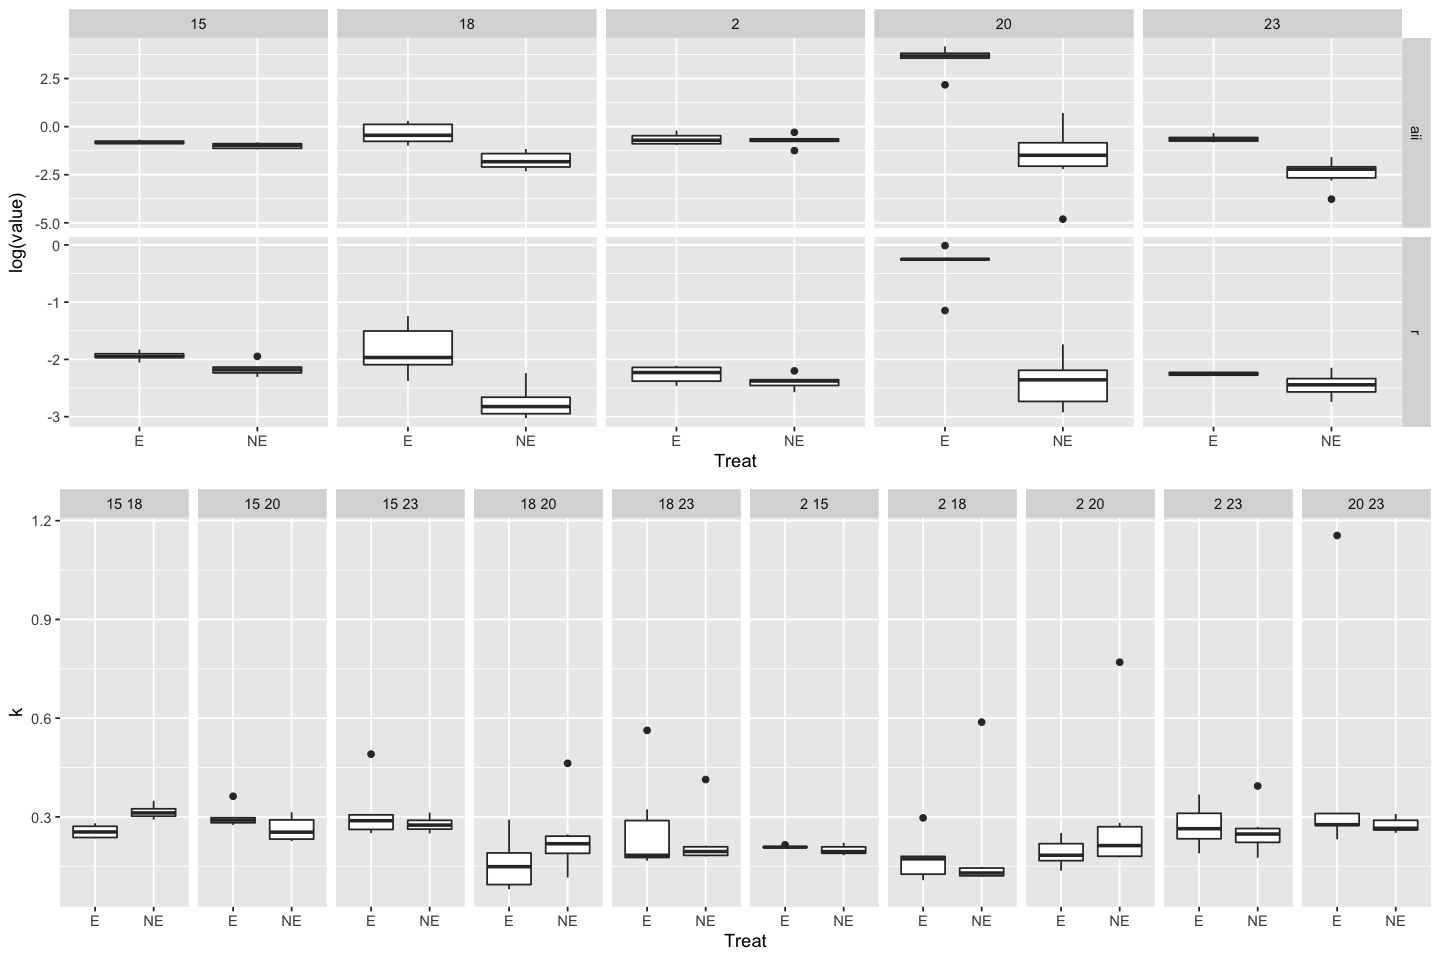

In [778]:
#plot params
options(repr.plot.width = 12, repr.plot.height = 8)
p1 <- df_sp %>%
    pivot_longer(c(r,aii)) %>%
    ggplot(aes(x=Treat,y = log(value)))+
        geom_boxplot()+
        facet_grid(name ~ ID, scales = "free")

p2 <- df_pair %>%
    ggplot(aes(x=Treat,y=k))+
        geom_boxplot()+
        facet_wrap(~paste(OTU_1,OTU_2), nrow = 1)

plot_grid(p1,p2, nrow = 2)

In [779]:
set.seed(1)

#estimat with bootstrapping
itt <- expand_grid(pair = unique(df_pair$ID), Treat = unique(df_pair$Treat)) %>%
    separate(pair, c("OTU_1","OTU_2"),"/", remove = F)

N <- 1000
a_est <- list()

#loop over estimates
for(i in 1:nrow(itt)){
    #get pairs
    OTU1 <- itt$OTU_1[i]
    OTU2 <- itt$OTU_2[i]

    #setup results
    df <- tibble(rep = 1:N, OTU_1 = OTU1, OTU_2 = OTU2,pairs = paste(OTU_1,OTU_2), Treatment = itt$Treat[i])

    #get individual params
    params_1 <- df_sp %>%
        filter(ID == OTU1, Treat == itt$Treat[i])
    params_2 <- df_sp %>%
        filter(ID == OTU2, Treat == itt$Treat[i])
    
    #get pairwise params
    params_12 <- df_pair %>%
        filter(OTU_1 == OTU1, OTU_2 == OTU2, Treat == itt$Treat[i])

    #get param samples
    r1 <- sample(params_1$r, N, replace = T)
    r2 <- sample(params_2$r, N, replace = T)
        
    a11 <- sample(params_1$aii, N, replace = T)
    a22 <- sample(params_2$aii, N, replace = T)

    Ktot <- sample(params_12$k, N, replace = T)
       
    #estimate
    a <- Ktot
    b <- r1 + r2
    c <- a11*r2 + a22*r1 - Ktot*a11*a22
    
    d <- (b^2) - (4*a*c)
    d[d < 0] <- NA
    
    a_1 <- (-b + sqrt(d) / (2*a))
    a_2 <- (-b - sqrt(d) / (2*a))
    
    #get feas
    #first estimate
    t1_1 <- (a11*a22 - (a_1^2))
    t2_1 <- a_1*r2 + a22*r1
    t3_1 <- a_1*r1 + a11*r2

    #second estimate
    t1_2 <- (a11*a22 - (a_2^2))
    t2_2 <- (a_2*r2) + (a22*r1)
    t3_2 <- (a_2*r1) + (a11*r2)
    
    #biomass sanity check
    df$Ktot <- Ktot
    df$x1 <- (t2_1 + t3_1) / t1_1
    df$x2 <- (t2_2 + t3_2) / t1_2
        
    #biomass based
    df$f1 <- (t2_1/t1_1) > 0  & (t3_1/t1_1) > 0
    df$f2 <- (t2_2/t1_2) > 0  & (t3_2/t1_2) > 0
    
    df$a_1 <- a_1
    df$a_2 <- a_2

    a_est[[i]] <- df
}

In [780]:
#get feasbility
feas_df <- bind_rows(a_est) %>%
     mutate(feas = case_when(f1 & f2 ~ "both",
                         f1 &!f2 ~ "a_1",
                        !f1 & f2 ~ "a_2",
                        !f1 &!f2 ~ "neither")) 

df_filter <- feas_df %>%
    pivot_longer(c(a_1,a_2)) %>%
    filter(feas == name, value > -5)

#allways a2
feas_df %>%
    pull(feas) %>%
    table()

.
    a_1     a_2    both neither 
   5186    1150    6393     430 

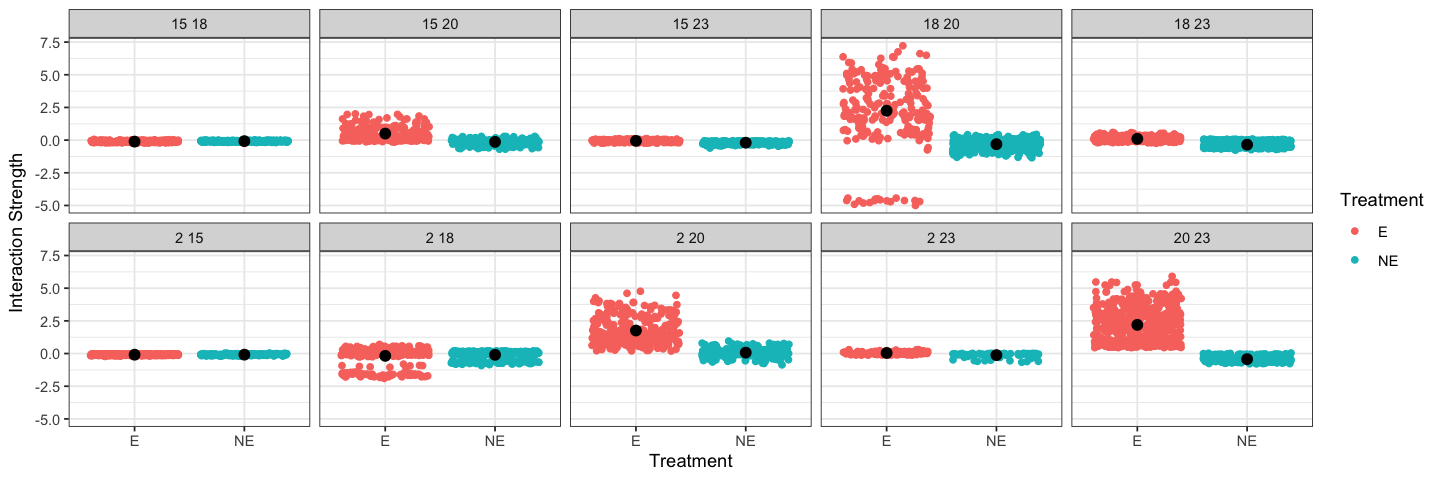

In [781]:
options(repr.plot.width = 12, repr.plot.height = 4)

#plot estimates
p1 <- df_filter %>%
    ggplot(aes(x=Treatment,y=value, colour = Treatment))+
        geom_point(position = "jitter")+
        stat_summary(fun = mean, color = "black")+
        facet_wrap(~pairs,nrow = 2)+
        ylab("Interaction Strength") +
        theme_bw()

suppressWarnings(plot(p1))

`summarise()` regrouping output by 'OTU_1', 'OTU_2' (override with `.groups` argument)



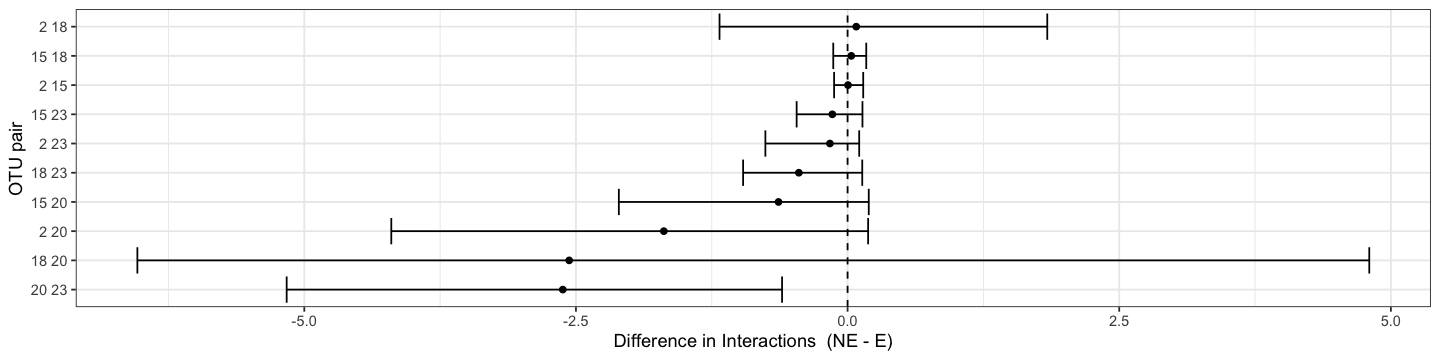

In [782]:
options(repr.plot.width = 12, repr.plot.height = 3)

p2 <- df_filter %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(mean = mean(value), Q2.5 = quantile(value,0.05),Q97.5 = quantile(value,0.95)) %>%
    pivot_wider(names_from = Treatment, values_from = c(mean,Q2.5,Q97.5)) %>%
    mutate(mean = mean_NE - mean_E, Q2.5 = Q2.5_NE - Q97.5_E, Q97.5 = Q97.5_NE - Q2.5_E, ) %>%
    ggplot(aes(y = fct_reorder(paste(OTU_1,OTU_2),mean), x = mean))+
        geom_point()+
        geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5))+
        geom_vline(xintercept = 0.0,linetype = 2) + 
        xlab("Difference in Interactions  (NE - E)") + ylab("OTU pair") +
        theme_bw()

p2

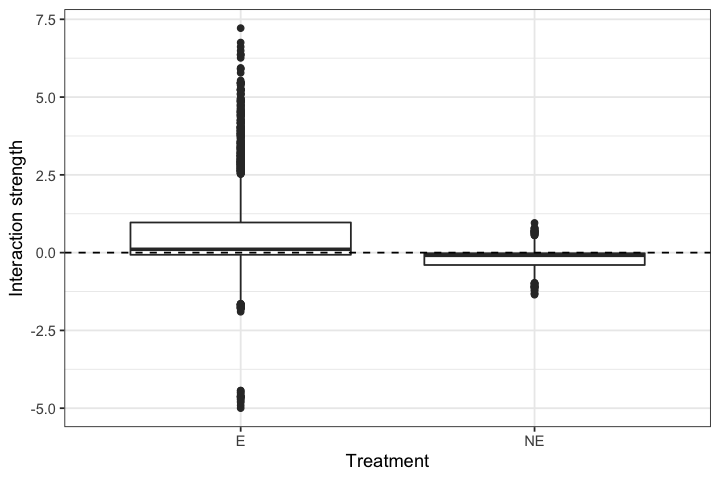

In [783]:
options(repr.plot.width = 6, repr.plot.height = 4)


p3 <-  df_filter %>%
    ggplot(aes(x=Treatment, y = value, group = Treatment))+
        geom_boxplot()+
        geom_hline(yintercept = 0.0, linetype = 2)+
        ylab("Interaction strength")+
        theme_bw()

p3

In [785]:
pl <- list(p1,p2,p3)
suppressWarnings(ggsave("arrange2x2.pdf", marrangeGrob(grobs = pl, nrow=1, ncol=1)))

Saving 7 x 7 in image



In [786]:
library(lme4)

mod <- feas_df %>%
    pivot_longer(c(a_1,a_2)) %>%
    filter(feas == name) %>%
    lmer(value ~ Treatment + (Treatment | pairs) , data = .)

summary(mod)

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ Treatment + (Treatment | pairs)
   Data: .

REML criterion at convergence: 15067.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.9506  -0.1575   0.0149   0.1817   6.8592 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 pairs    (Intercept) 0.8799   0.9380        
          TreatmentNE 0.9897   0.9948   -0.99
 Residual             0.6229   0.7893        
Number of obs: 6336, groups:  pairs, 10

Fixed effects:
            Estimate Std. Error t value
(Intercept)   0.5970     0.2970   2.010
TreatmentNE  -0.7707     0.3154  -2.444

Correlation of Fixed Effects:
            (Intr)
TreatmentNE -0.989